# Collaborative filtering

## Load libraries

In [1]:
import pandas as pd
import dexplot
import random

## Read data

In [2]:
ratings = pd.read_csv('./goodbooks-10k-1.0/ratings.csv')
#books = pd.read_csv('./goodbooks-10k-1.0/books.csv')
display(ratings.head(5))

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
print(f'Number of ratings is {len(ratings)}')
print(f'Number of users who rated at least one book is {len(ratings.user_id.unique())}')

Number of ratings is 5976479
Number of users who rated at least one book is 53424


There is almost a 6 million ratings - it would be hard to process such an amount of data. We have to reduce the number of observations.

Let's see the statistics for number of books rated per user:

In [4]:
def grouping(data, col_name):
    return data.groupby(col_name)['rating'].count()

In [5]:
def check_ratings(data, col_name):
    data_grouped = grouping(data, col_name)
    title = 'Number of ratings per '+ str(col_name[:-3])
    display(dexplot.hist(val='rating',data=data_grouped, title=title, cmap='plasma'))
    print('Statistics for dataframe grouped by '+ str(col_name) +':')
    print(data_grouped.describe())

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


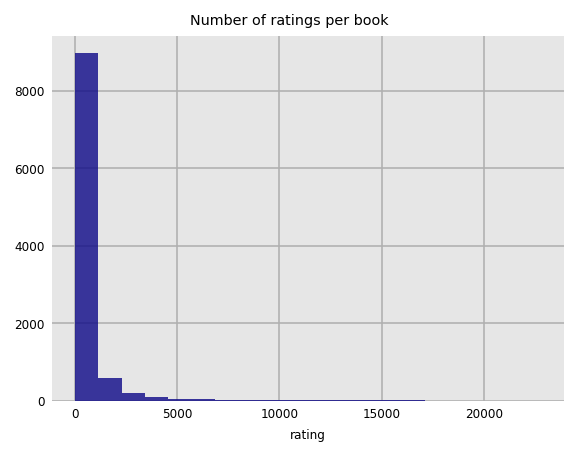

Statistics for dataframe grouped by book_id:
count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: rating, dtype: float64


In [6]:
check_ratings(ratings, 'book_id')

Let's remove books which has less than 248 reviews.

In [7]:
grouped_by_book = grouping(ratings, 'book_id')
ratings = ratings[ratings.book_id.isin(grouped_by_book[grouped_by_book >=400].index)]
ratings.shape

(4614057, 3)

Let's see the statistics for number of ratings per user:

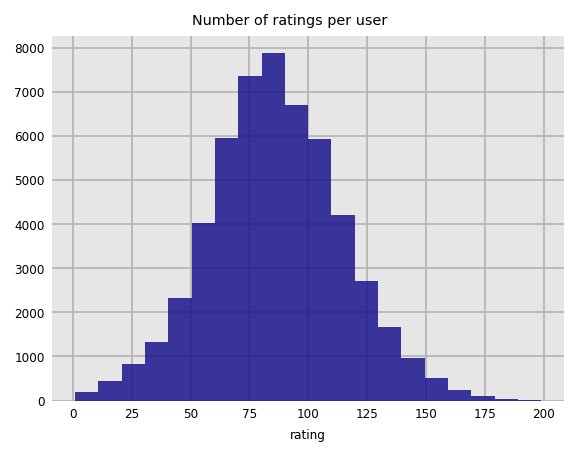

Statistics for dataframe grouped by user_id:
count    53424.000000
mean        86.366745
std         28.334976
min          1.000000
25%         68.000000
50%         86.000000
75%        104.000000
max        199.000000
Name: rating, dtype: float64


In [8]:
check_ratings(ratings, 'user_id')

Let's remove users which rated less than 100 books.

In [9]:
grouped_by_user = grouping(ratings, 'user_id')
ratings = ratings[ratings.user_id.isin(grouped_by_user[grouped_by_user >=120].index)]
ratings.shape

(849199, 3)

Check if there are any NaNs in data

In [10]:
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

Check if there is any users who give two ratings to the same book.

In [11]:
ratings.duplicated(['user_id','book_id']).sum()

0

In [12]:
ratings.rating.describe()

count    849199.000000
mean          3.857025
std           1.010149
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [13]:
print(f'Total number of users is {len(ratings.user_id.unique())}.')
print(f'Total number of rated books is {len(ratings.book_id.unique())}.')
print(f'Total number of ratings is {len(ratings)}.')

Total number of users is 6280.
Total number of rated books is 3164.
Total number of ratings is 849199.


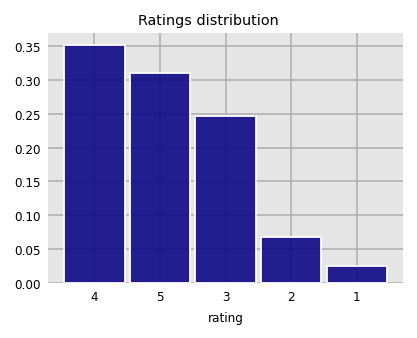

In [14]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

The most common rating is 4. 

For the prediction I will use the library Surprise.

In [15]:
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans
from surprise import accuracy

In [16]:
random.seed(6)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
train = data

In [17]:
random.shuffle(raw_ratings)

Divide data into train and test

In [18]:
train_size = int(.8 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]                             
test_raw_ratings = raw_ratings[train_size:]                                 
train.raw_ratings = train_raw_ratings

In [19]:
data.raw_ratings = train_raw_ratings

In [20]:
model_dict = {'KNNBasic': KNNBasic,'KNNBaseline': KNNBaseline,
              'KNNWithZScore': KNNWithZScore, 'KNNWithMeans' :KNNWithMeans}
param_grid = {'k': [20], 
              'sim_options': {'user_based': [False]}
             }
results = []

In [21]:
for name, model in model_dict.items():
    grid = GridSearchCV(model,param_grid, cv = 2)
    grid.fit(data)
    print(f' Best params for model {str(model)} are {grid.best_params}')
    results.append((name, grid.best_estimator['rmse'], grid.best_estimator['rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBasic'> are {'rmse': {'k': 20, 'sim_options': {'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'user_based': False}}}
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBaseline'> are {'rmse': {'k': 20, 'sim_options': {'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'user_based': False}}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNWithZScore'> are {'rmse': {'k': 20,

In [23]:
rmse = []
mae = []
for name, model,_ in results:
    print(name)                                                     
                                                                           
    # now test on the trainset                                                 
    trainset = data.build_full_trainset()
    model.fit(trainset)                                          

    # Compute biased accuracy on A
    predictions = model.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(test_raw_ratings)  # testset is now the set B
    predictions = model.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)                                                                                        
    rmse_score = accuracy.rmse(predictions)
    mae_score = accuracy.mae(predictions)
    print("RMSE: {}".format(rmse_score))
    print("MAE: {}".format(mae_score))
    rmse.append(rmse_score)
    mae.append(mae_score)

KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6073
Unbiased accuracy on B, RMSE: 0.8879
RMSE: 0.8879
MAE:  0.6904
RMSE: 0.8879321891035324
MAE: 0.6904194959575907
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6067
Unbiased accuracy on B, RMSE: 0.8659
RMSE: 0.8659
MAE:  0.6729
RMSE: 0.8658745535748417
MAE: 0.6728855922525602
KNNWithZScore
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6086
Unbiased accuracy on B, RMSE: 0.8713
RMSE: 0.8713
MAE:  0.6757
RMSE: 0.8713008773631512
MAE: 0.6756551652621126
KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6103
Unbiased accuracy on B, RMSE: 0.8678
RMSE: 0.8678
MAE:  0.6753
RMSE: 0.8677815921058591
MAE: 0.6753203820054791


In [25]:
import pandas as pd
d = {'rmse': rmse, 
     'mae': mae
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline',
              'KNNWithZScore','KNNWithMeans'])
color = (df.rmse == df.rmse.min()).map({True: 'background-color: yellow', False: 'background_color: white'})
df.style.apply(lambda s: color)

,Method,rmse,mae
0,KNNBasic,0.887932,0.690419
1,KNNBaseline,0.865875,0.672886
2,KNNWithZScore,0.871301,0.675655
3,KNNWithMeans,0.867782,0.675320


Top n-recommendations

In [91]:
def get_top_n(user_id, model,n=10):
    rated_books = list(ratings[ratings.user_id  ==user_id].book_id)
    ratings_set = [(user_id,book_id,0) for book_id in set(ratings[~ratings.book_id.isin(rated_books)].book_id)]
    predictions = model.test(ratings_set)

    top_n = list()
    for _, iid, true_r, est, _ in predictions:
        top_n.append((iid, est))

    # Then sort the predictions for user and retrieve the k highest ones.
    top_n.sort(key=lambda x: x[1], reverse=True)
    top_n = top_n[:n]

    return top_n

top_n = get_top_n(4, results[1][1],n=10)

# Print the recommended items for each user
top_n

[(422, 4.710913493295039),
 (2353, 4.668107552304876),
 (862, 4.657017890084698),
 (144, 4.62833853931778),
 (1029, 4.622729671193017),
 (780, 4.606268949739803),
 (1010, 4.582512166334511),
 (740, 4.578840551402136),
 (3395, 4.57288017595366),
 (760, 4.57120941278542)]

In [114]:
ids = [book[0] for book in top_n ]

In [98]:
ratings[ratings.user_id ==4].sort_values(by='rating',ascending=False)[:10]

,user_id,book_id,rating
195100,4,383,5
2322,4,10,5
101,4,245,5
267,4,497,5
90,4,42,5
271,4,489,5
273,4,1380,5
84,4,87,5
277,4,3469,5
1238,4,81,5


In [108]:
books = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/books.csv', usecols=['book_id','title','authors'])

Names mapping

In [101]:
ratings.shape

(849199, 3)

In [109]:
ratings_with_names = pd.merge(ratings, books,how='left', on='book_id')

In [117]:
ratings_with_names.drop(['user_id','rating'],axis=1, inplace=True)

In [118]:
ratings_with_names.drop_duplicates(inplace=True)

In [110]:
len(ratings_with_names)

849199

In [119]:
ratings_with_names[ratings_with_names.book_id.isin(ids)]

,book_id,authors,title
390,760,Orson Scott Card,"Ender's Shadow (Ender's Shadow, #1)"
1994,1010,Bill Watterson,The Essential Calvin and Hobbes: A Calvin and ...
1996,780,"Bill Watterson, G.B. Trudeau",Calvin and Hobbes
2660,2353,"Neil Gaiman, Matt Wagner, George Pratt, Dick G...",Season of Mists (The Sandman #4)
2666,3395,"Neil Gaiman, Marc Hempel, Richard Case, D'Isra...",The Kindly Ones (The Sandman #9)
5039,740,"Laura Ingalls Wilder, Garth Williams","The Little House Collection (Little House, #1-9)"
8273,422,J.K. Rowling,"Harry Potter Boxset (Harry Potter, #1-7)"
164714,144,Laura Hillenbrand,"Unbroken: A World War II Story of Survival, Re..."
466643,862,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)"
514347,1029,"Brian K. Vaughan, Fiona Staples","Saga, Vol. 1 (Saga, #1)"
